In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from medpy.metric import dc, assd
import torch.nn.functional as F
import torchio as tio
import nibabel as nib

In [2]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torch.nn.functional as F

class BrainSegmentationDataset(Dataset):
    def __init__(self, t1c_dir, t2f_dir, seg_dir, transforms=None):
        self.t1c_dir = t1c_dir
        self.t2f_dir = t2f_dir
        self.seg_dir = seg_dir
        self.transforms = transforms

        # Create a list of all seg images (patient + slice)
        self.seg_files = [os.path.join(root, file) for root, _, files in os.walk(seg_dir) 
                          for file in files if os.path.getsize(os.path.join(root, file)) > 141]

    def __len__(self):
        return len(self.seg_files)

    def __getitem__(self, idx):
        seg_img_path = self.seg_files[idx]
        
        mask = Image.open(seg_img_path).convert('L')
        
        mask = np.array(mask, dtype = np.int64)
        
        background_mask = (mask == 0).astype(np.float32)
        class1_mask = (mask == 85).astype(np.float32)
        class2_mask = (mask == 170).astype(np.float32)
        class3_mask = (mask == 255).astype(np.float32)
        
        mask = np.dstack([background_mask, class1_mask, class2_mask, class3_mask])
        mask = np.argmax(mask, axis = 2)
        
        # Corresponding input images
        t1c_img_path = seg_img_path.replace('seg', 't1c')
        t1c_img = Image.open(t1c_img_path).convert('L')  # load and convert t1c image
        t1c_tensor = torch.from_numpy(np.array(t1c_img,dtype = np.float32)[None, ...])/255.0
#         t1c_tensor = self.transforms(t1c_img)  # transform to tensor

        t2f_img_path = seg_img_path.replace('seg', 't2f')
        t2f_img = Image.open(t2f_img_path)  # load and convert t2f image
        t2f_tensor = torch.from_numpy(np.array(t2f_img,dtype = np.float32)[None, ...])/255.0
#         t2f_tensor = self.transforms(t2f_img)  # transform to tensor

        # Stack t1c and t2f tensors along the channel dimension
        inputs = torch.cat((t1c_tensor, t2f_tensor), dim=0)

        return inputs, mask


In [3]:
from torchvision import transforms

data_transforms = transforms.Compose([
     # You can modify this as per your model's input size
    transforms.ToTensor(),
])

dataset = BrainSegmentationDataset(t1c_dir="BraTS_2023_train/t1cSliced", t2f_dir="BraTS_2023_train/t2fSliced", seg_dir="BraTS_2023_train/segSliced", transforms=data_transforms)


In [4]:
from torch.utils.data import DataLoader, random_split

# Split dataset into training set and validation set
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create a DataLoader for both sets
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)


In [5]:
print(len(train_dataset))
print(len(train_loader))
data, labels = next(iter(train_loader))
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
data, labels = next(iter(val_loader))
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)


63531
15883
Data shape: torch.Size([4, 2, 256, 256])
Labels shape: torch.Size([4, 256, 256])
Data shape: torch.Size([4, 2, 256, 256])
Labels shape: torch.Size([4, 256, 256])


In [6]:
# class UNet(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(UNet, self).__init__()

#         # Downsample path
#         self.conv1 = self.double_conv(in_channels, 64)
#         self.pool1 = nn.MaxPool2d(2)
#         self.conv2 = self.double_conv(64, 128)
#         self.pool2 = nn.MaxPool2d(2)
#         self.conv3 = self.double_conv(128, 256)
#         self.pool3 = nn.MaxPool2d(2)
#         self.conv4 = self.double_conv(256, 512)
#         self.pool4 = nn.MaxPool2d(2)
#         self.conv5 = self.double_conv(512, 1024)
#         self.pool5 = nn.MaxPool2d(2)

#         # Bottom
#         self.conv6 = self.double_conv(1024, 2048)

#         # Upsample path
#         self.up7 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2)
#         self.conv7 = self.double_conv(2048, 1024)
#         self.up8 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
#         self.conv8 = self.double_conv(1024, 512)
#         self.up9 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
#         self.conv9 = self.double_conv(512, 256)
#         self.up10 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
#         self.conv10 = self.double_conv(256, 128)
#         self.up11 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
#         self.conv11 = self.double_conv(128, 64)

#         # Output
#         self.conv12 = nn.Conv2d(64, out_channels, kernel_size=1)

#     def double_conv(self, in_channels, out_channels):
#         return nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         # Downsample path
#         c1 = self.conv1(x)
#         p1 = self.pool1(c1)
#         c2 = self.conv2(p1)
#         p2 = self.pool2(c2)
#         c3 = self.conv3(p2)
#         p3 = self.pool3(c3)
#         c4 = self.conv4(p3)
#         p4 = self.pool4(c4)
#         c5 = self.conv5(p4)
#         p5 = self.pool5(c5)

#         # Bottom
#         c6 = self.conv6(p5)

#         # Upsample path
#         up7 = self.up7(c6)
#         merge7 = torch.cat([up7, c5], dim=1)
#         c7 = self.conv7(merge7)
#         up8 = self.up8(c7)
#         merge8 = torch.cat([up8, c4], dim=1)
#         c8 = self.conv8(merge8)
#         up9 = self.up9(c8)
#         merge9 = torch.cat([up9, c3], dim=1)
#         c9 = self.conv9(merge9)
#         up10 = self.up10(c9)
#         merge10 = torch.cat([up10, c2], dim=1)
#         c10 = self.conv10(merge10)
#         up11 = self.up11(c10)
#         merge11 = torch.cat([up11, c1], dim=1)
#         c11 = self.conv11(merge11)

#         # Output
#         out = self.conv12(c11)
#         return out
    
#     def predict(self, x):
#         out = self.forward(x)
#         _, preds = torch.max(out, 1)
#         return preds


In [7]:
 class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm, n=2, ks=3, stride=1, padding=1):
        super(unetConv2, self).__init__()
        self.n = n
        self.ks = ks
        self.stride = stride
        self.padding = padding
        s = stride
        p = padding
        
        if is_batchnorm:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.BatchNorm2d(out_size), nn.ReLU(inplace=True),)
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size
        else:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p), nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        # initialise the blocks
        for m in self.children():
            init_weights(m, init_type='kaiming')


    def forward(self, inputs):
        x = inputs
        for i in range(1, self.n + 1):
            conv = getattr(self, 'conv%d' % i)
            x = conv(x)
        return x


In [8]:
import torch
import torch.nn as nn
from torch.nn import init


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_xavier(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_normal_(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.xavier_normal_(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_kaiming(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_orthogonal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.orthogonal_(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.orthogonal_(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def init_weights(net, init_type='normal'):
    if init_type == 'normal':
        net.apply(weights_init_normal)
    elif init_type == 'xavier':
        net.apply(weights_init_xavier)
    elif init_type == 'kaiming':
        net.apply(weights_init_kaiming)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError('initialization method [%s] is not implemented' % init_type)

In [9]:
class UNet3Plus(nn.Module):
    def __init__(self, n_channels=2, n_classes=4, bilinear=True, feature_scale=4,
                 is_deconv=True, is_batchnorm=True):
        super(UNet3Plus, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.feature_scale = feature_scale
        self.is_deconv = is_deconv
        self.is_batchnorm = is_batchnorm
        filters = [64, 128, 256, 512, 512]

        ## -------------Encoder--------------
        self.conv1 = unetConv2(self.n_channels, filters[0], self.is_batchnorm)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = unetConv2(filters[0], filters[1], self.is_batchnorm)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = unetConv2(filters[1], filters[2], self.is_batchnorm)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = unetConv2(filters[2], filters[3], self.is_batchnorm)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        self.conv5 = unetConv2(filters[3], filters[4], self.is_batchnorm)

        ## -------------Decoder--------------
        self.CatChannels = filters[0]
        self.CatBlocks = 5
        self.UpChannels = self.CatChannels * self.CatBlocks

        '''stage 4d'''
        # h1->320*320, hd4->40*40, Pooling 8 times
        self.h1_PT_hd4 = nn.MaxPool2d(8, 8, ceil_mode=True)
        self.h1_PT_hd4_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd4_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd4->40*40, Pooling 4 times
        self.h2_PT_hd4 = nn.MaxPool2d(4, 4, ceil_mode=True)
        self.h2_PT_hd4_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_PT_hd4_relu = nn.ReLU(inplace=True)

        # h3->80*80, hd4->40*40, Pooling 2 times
        self.h3_PT_hd4 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h3_PT_hd4_conv = nn.Conv2d(filters[2], self.CatChannels, 3, padding=1)
        self.h3_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h3_PT_hd4_relu = nn.ReLU(inplace=True)

        # h4->40*40, hd4->40*40, Concatenation
        self.h4_Cat_hd4_conv = nn.Conv2d(filters[3], self.CatChannels, 3, padding=1)
        self.h4_Cat_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h4_Cat_hd4_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd4->40*40, Upsample 2 times
        self.hd5_UT_hd4 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd5_UT_hd4_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd4_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4)
        self.conv4d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn4d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu4d_1 = nn.ReLU(inplace=True)

        '''stage 3d'''
        # h1->320*320, hd3->80*80, Pooling 4 times
        self.h1_PT_hd3 = nn.MaxPool2d(4, 4, ceil_mode=True)
        self.h1_PT_hd3_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd3_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd3->80*80, Pooling 2 times
        self.h2_PT_hd3 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h2_PT_hd3_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_PT_hd3_relu = nn.ReLU(inplace=True)

        # h3->80*80, hd3->80*80, Concatenation
        self.h3_Cat_hd3_conv = nn.Conv2d(filters[2], self.CatChannels, 3, padding=1)
        self.h3_Cat_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h3_Cat_hd3_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd4->80*80, Upsample 2 times
        self.hd4_UT_hd3 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd4_UT_hd3_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd3_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd4->80*80, Upsample 4 times
        self.hd5_UT_hd3 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd5_UT_hd3_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd3_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3, hd5_UT_hd3)
        self.conv3d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn3d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu3d_1 = nn.ReLU(inplace=True)

        '''stage 2d '''
        # h1->320*320, hd2->160*160, Pooling 2 times
        self.h1_PT_hd2 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h1_PT_hd2_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd2_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd2->160*160, Concatenation
        self.h2_Cat_hd2_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_Cat_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_Cat_hd2_relu = nn.ReLU(inplace=True)

        # hd3->80*80, hd2->160*160, Upsample 2 times
        self.hd3_UT_hd2 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd3_UT_hd2_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd3_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd3_UT_hd2_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd2->160*160, Upsample 4 times
        self.hd4_UT_hd2 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd4_UT_hd2_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd2_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd2->160*160, Upsample 8 times
        self.hd5_UT_hd2 = nn.Upsample(scale_factor=8, mode='bilinear')  # 14*14
        self.hd5_UT_hd2_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd2_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2)
        self.conv2d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn2d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu2d_1 = nn.ReLU(inplace=True)

        '''stage 1d'''
        # h1->320*320, hd1->320*320, Concatenation
        self.h1_Cat_hd1_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_Cat_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_Cat_hd1_relu = nn.ReLU(inplace=True)

        # hd2->160*160, hd1->320*320, Upsample 2 times
        self.hd2_UT_hd1 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd2_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd2_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd2_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd3->80*80, hd1->320*320, Upsample 4 times
        self.hd3_UT_hd1 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd3_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd3_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd3_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd1->320*320, Upsample 8 times
        self.hd4_UT_hd1 = nn.Upsample(scale_factor=8, mode='bilinear')  # 14*14
        self.hd4_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd1->320*320, Upsample 16 times
        self.hd5_UT_hd1 = nn.Upsample(scale_factor=16, mode='bilinear')  # 14*14
        self.hd5_UT_hd1_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd1_relu = nn.ReLU(inplace=True)

        # fusion(h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, hd5_UT_hd1)
        self.conv1d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn1d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu1d_1 = nn.ReLU(inplace=True)

        # output
        self.outconv1 = nn.Conv2d(self.UpChannels, n_classes, 3, padding=1)

        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weights(m, init_type='kaiming')
            elif isinstance(m, nn.BatchNorm2d):
                init_weights(m, init_type='kaiming')


    def forward(self, inputs):
        ## -------------Encoder-------------
        h1 = self.conv1(inputs)  # h1->320*320*64

        h2 = self.maxpool1(h1)
        h2 = self.conv2(h2)  # h2->160*160*128

        h3 = self.maxpool2(h2)
        h3 = self.conv3(h3)  # h3->80*80*256

        h4 = self.maxpool3(h3)
        h4 = self.conv4(h4)  # h4->40*40*512

        h5 = self.maxpool4(h4)
        hd5 = self.conv5(h5)  # h5->20*20*1024

        ## -------------Decoder-------------
        h1_PT_hd4 = self.h1_PT_hd4_relu(self.h1_PT_hd4_bn(self.h1_PT_hd4_conv(self.h1_PT_hd4(h1))))
        h2_PT_hd4 = self.h2_PT_hd4_relu(self.h2_PT_hd4_bn(self.h2_PT_hd4_conv(self.h2_PT_hd4(h2))))
        h3_PT_hd4 = self.h3_PT_hd4_relu(self.h3_PT_hd4_bn(self.h3_PT_hd4_conv(self.h3_PT_hd4(h3))))
        h4_Cat_hd4 = self.h4_Cat_hd4_relu(self.h4_Cat_hd4_bn(self.h4_Cat_hd4_conv(h4)))
        hd5_UT_hd4 = self.hd5_UT_hd4_relu(self.hd5_UT_hd4_bn(self.hd5_UT_hd4_conv(self.hd5_UT_hd4(hd5))))
        hd4 = self.relu4d_1(self.bn4d_1(self.conv4d_1(torch.cat((h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4), 1)))) # hd4->40*40*UpChannels

        h1_PT_hd3 = self.h1_PT_hd3_relu(self.h1_PT_hd3_bn(self.h1_PT_hd3_conv(self.h1_PT_hd3(h1))))
        h2_PT_hd3 = self.h2_PT_hd3_relu(self.h2_PT_hd3_bn(self.h2_PT_hd3_conv(self.h2_PT_hd3(h2))))
        h3_Cat_hd3 = self.h3_Cat_hd3_relu(self.h3_Cat_hd3_bn(self.h3_Cat_hd3_conv(h3)))
        hd4_UT_hd3 = self.hd4_UT_hd3_relu(self.hd4_UT_hd3_bn(self.hd4_UT_hd3_conv(self.hd4_UT_hd3(hd4))))
        hd5_UT_hd3 = self.hd5_UT_hd3_relu(self.hd5_UT_hd3_bn(self.hd5_UT_hd3_conv(self.hd5_UT_hd3(hd5))))
        hd3 = self.relu3d_1(self.bn3d_1(self.conv3d_1(torch.cat((h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3, hd5_UT_hd3), 1)))) # hd3->80*80*UpChannels

        h1_PT_hd2 = self.h1_PT_hd2_relu(self.h1_PT_hd2_bn(self.h1_PT_hd2_conv(self.h1_PT_hd2(h1))))
        h2_Cat_hd2 = self.h2_Cat_hd2_relu(self.h2_Cat_hd2_bn(self.h2_Cat_hd2_conv(h2)))
        hd3_UT_hd2 = self.hd3_UT_hd2_relu(self.hd3_UT_hd2_bn(self.hd3_UT_hd2_conv(self.hd3_UT_hd2(hd3))))
        hd4_UT_hd2 = self.hd4_UT_hd2_relu(self.hd4_UT_hd2_bn(self.hd4_UT_hd2_conv(self.hd4_UT_hd2(hd4))))
        hd5_UT_hd2 = self.hd5_UT_hd2_relu(self.hd5_UT_hd2_bn(self.hd5_UT_hd2_conv(self.hd5_UT_hd2(hd5))))
        hd2 = self.relu2d_1(self.bn2d_1(self.conv2d_1(torch.cat((h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2), 1)))) # hd2->160*160*UpChannels

        h1_Cat_hd1 = self.h1_Cat_hd1_relu(self.h1_Cat_hd1_bn(self.h1_Cat_hd1_conv(h1)))
        hd2_UT_hd1 = self.hd2_UT_hd1_relu(self.hd2_UT_hd1_bn(self.hd2_UT_hd1_conv(self.hd2_UT_hd1(hd2))))
        hd3_UT_hd1 = self.hd3_UT_hd1_relu(self.hd3_UT_hd1_bn(self.hd3_UT_hd1_conv(self.hd3_UT_hd1(hd3))))
        hd4_UT_hd1 = self.hd4_UT_hd1_relu(self.hd4_UT_hd1_bn(self.hd4_UT_hd1_conv(self.hd4_UT_hd1(hd4))))
        hd5_UT_hd1 = self.hd5_UT_hd1_relu(self.hd5_UT_hd1_bn(self.hd5_UT_hd1_conv(self.hd5_UT_hd1(hd5))))
        hd1 = self.relu1d_1(self.bn1d_1(self.conv1d_1(torch.cat((h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, hd5_UT_hd1), 1)))) # hd1->320*320*UpChannels

        d1 = self.outconv1(hd1)  # d1->320*320*n_classes
        return F.sigmoid(d1)



In [10]:
def plot_preds_and_masks(preds, masks):
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    for i, (pred, mask) in enumerate(zip(preds, masks)):
#         pred = torch.argmax(pred, dim=0)  # Convert from one-hot encoding to class labels
#         mask = torch.argmax(mask, dim=0)  # Convert from one-hot encoding to class labels

        axs[0, i].imshow(pred.cpu().detach().numpy(), cmap = 'gray')
        axs[0, i].title.set_text("Predicted")
        axs[1, i].imshow(mask.cpu().detach().numpy(), cmap = 'gray')
        axs[1, i].title.set_text("Ground Truth")
    plt.show()


In [11]:
def compute_metrics(pred, target):
    assert pred.shape == target.shape
    batch_size, num_classes, _, _ = pred.shape
    DSCs = []
    ASSDs = []
    for image_idx in range(batch_size):
        dsc_per_class = []
        assd_per_class = []
        for class_idx in range(num_classes):
            pred_class = pred[image_idx, class_idx]
            target_class = target[image_idx, class_idx]

            # Check if the prediction and the target contain any objects
            pred_has_object = np.count_nonzero(pred_class) > 0
            target_has_object = np.count_nonzero(target_class) > 0
            
            if pred_has_object and target_has_object:
                dsc = dc(pred_class, target_class)
                assd_val = assd(pred_class, target_class)
            elif not pred_has_object and not target_has_object:
                dsc = 1.0  # perfect similarity
                assd_val = 0.0  # no distance
            else:
                dsc = 0.0  # no overlap
                assd_val = 362  # maximum distance

            dsc_per_class.append(dsc)
            assd_per_class.append(assd_val)
        
        DSCs.append(dsc_per_class)
        ASSDs.append(assd_per_class)
    DSCs = np.array(DSCs)
    ASSDs = np.array(ASSDs)
        
    return np.mean(DSCs, axis = 0), np.mean(ASSDs, axis = 0)

In [12]:
from tqdm import tqdm
def train_model(num_epochs):
    # Create dataset and dataloader for T1
#     training_dataset_T1 = train_loader
#     validation_dataset_T1 = val_loader

    training_dataloader_T1 = train_loader
    validation_dataloader_T1 = val_loader

    # Check if saved model exists, if so load it, otherwise initialize a new one
    model_path = "unet_model_3.pth"
    if os.path.isfile(model_path):
        print("Loading model...")
        model = UNet3Plus(n_channels = 2)
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        print("Model loaded.")
    else:
        print("Initializing new model...")
        model = UNet3Plus(n_channels = 2).to(device)
        print("New model initialized.")

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)

    for epoch in range(num_epochs):
        print(f"Epoch { epoch + 1 }/{ num_epochs }")
        print("-------------------------")

        # Initialize the running loss to zero
        running_loss = 0.0

        # Initialize counter for the number of batches
        num_batches = 0

        # Initialize the running DSC and ASSD
        running_train_dsc = []
        running_train_assd = []

        # Training phase
        model.train() 
        for i, (images, masks) in enumerate(tqdm(training_dataloader_T1)):
            images = images.to(device)
            masks = masks.to(device)
#             masks = masks.float().squeeze(1).permute(0, 3, 2, 1)

            # Forward pass
            outputs = model(images)
            
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1 == 0 and i == 0:
                print("Training Prediction Visualization:")
                _, preds = torch.max(outputs[:2], 1)
#                 print(outputs.shape,masks.shape)
                plot_preds_and_masks(preds,masks[:2])

            # Update the running loss and batch count
            running_loss += loss.item()
            num_batches += 1


            if epoch % 1 == 0:
                _, preds = torch.max(outputs, 1)
                preds_one_hot = F.one_hot(preds, num_classes = 4)
                preds_one_hot = preds_one_hot.permute(0, 3, 1, 2)

                masks_one_hot = F.one_hot(masks, num_classes = 4)
                masks_one_hot = masks_one_hot.permute(0, 3, 1, 2)

                train_dsc, train_assd = compute_metrics(preds_one_hot.cpu().numpy(), masks_one_hot.cpu().numpy())
                running_train_dsc.append(train_dsc)
                running_train_assd.append(train_assd)


        # Compute and print the average training loss for this epoch
        avg_train_loss = running_loss / num_batches
        print(f"\nAverage Training Loss: {avg_train_loss}")

        if epoch % 1 == 0:
            print(f"\nAverage Training DSC: {np.mean(np.array(running_train_dsc), axis = 0)}\nAverage Training ASSD: {np.mean(np.array(running_train_assd), axis = 0)}")

        # Validation phase
        model.eval()  # Set model to evaluate mode
        running_val_loss = 0.0
        num_val_batches = 0
        running_val_dsc = []
        running_val_assd = []

        with torch.no_grad():  # No need to track gradients in validation phase
            for i, (val_images, val_masks) in enumerate(tqdm(validation_dataloader_T1)):
                val_images = val_images.to(device)
                val_masks = val_masks.to(device)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_masks)
                
                running_val_loss += val_loss.item()
                num_val_batches += 1


                if epoch % 1 == 0 and i == 0:
                    print("Validation Prediction Visualization:")
                    _, preds = torch.max(val_outputs[:2], 1)
                    
                    plot_preds_and_masks(preds, val_masks[:2])


                if epoch % 1 == 0:
                    _, val_preds = torch.max(val_outputs, 1)
                    val_preds_one_hot = F.one_hot(val_preds, num_classes = 4)
                    val_preds_one_hot = val_preds_one_hot.permute(0, 3, 1, 2)

                    val_masks_one_hot = F.one_hot(val_masks, num_classes = 4)
                    val_masks_one_hot = val_masks_one_hot.permute(0, 3, 1, 2)
                    
                    val_dsc, val_assd = compute_metrics(val_preds_one_hot.cpu().numpy(), val_masks_one_hot.cpu().numpy())
                    running_val_dsc.append(val_dsc)
                    running_val_assd.append(val_assd)

        # Compute and print the average validation loss for this epoch
        avg_val_loss = running_val_loss / num_val_batches
        print(f"Average Validation Loss: {avg_val_loss}")

        if epoch % 1 == 0:
            print(f"\nAverage Validation DSC: {np.mean(np.array(running_val_dsc), axis = 0)}\nAverage Validation ASSD: {np.mean(np.array(running_val_assd), axis = 0)}")

        # Save the trained model
        torch.save(model.state_dict(), "unet_model_3.pth")

    
    return model

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing new model...
New model initialized.
Epoch 1/50
-------------------------


  0%|          | 0/15883 [00:00<?, ?it/s]

Training Prediction Visualization:


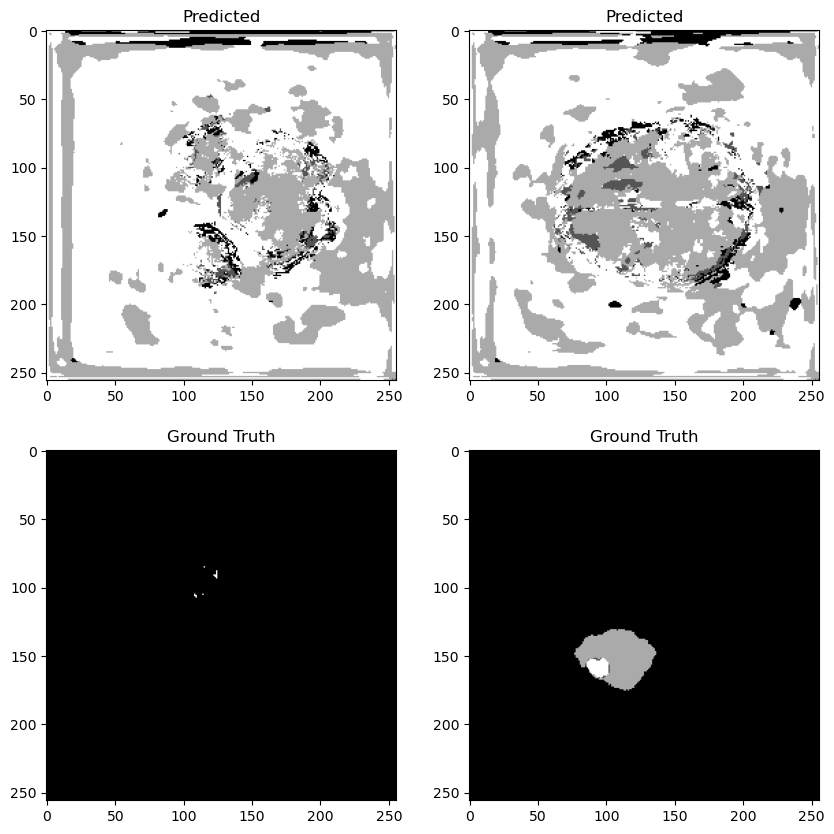

100%|██████████| 15883/15883 [1:32:05<00:00,  2.87it/s]



Average Training Loss: 0.7511019838522027

Average Training DSC: [0.99717172 0.76072525 0.70108038 0.64142556]
Average Training ASSD: [ 0.62477449 47.6490347  50.64466857 36.32583457]


  0%|          | 0/3971 [00:00<?, ?it/s]

Validation Prediction Visualization:


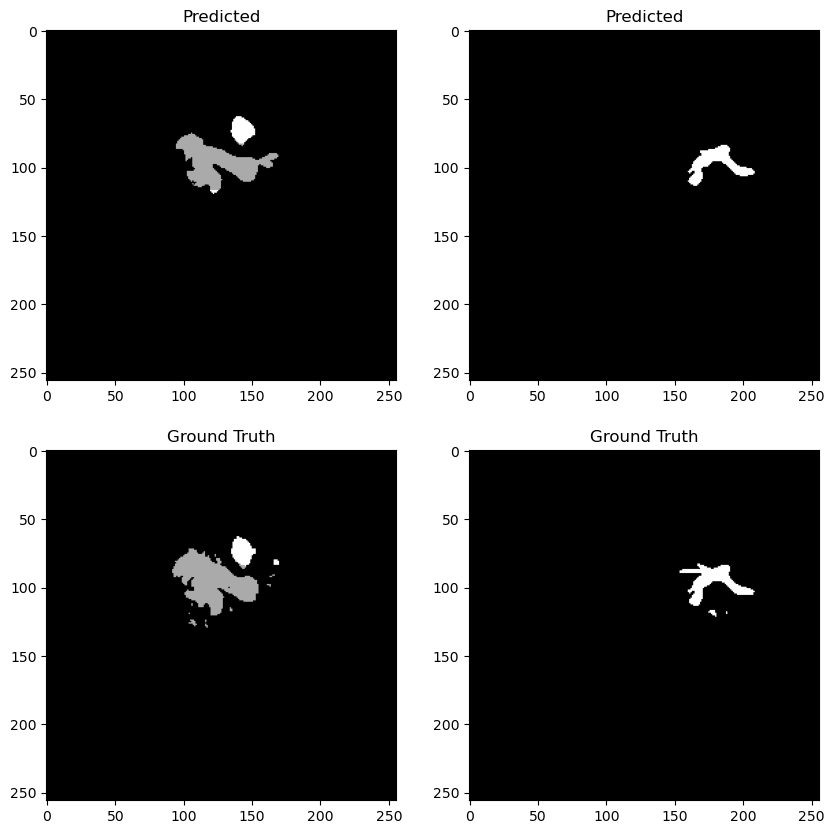

100%|██████████| 3971/3971 [12:12<00:00,  5.42it/s]


Average Validation Loss: 0.7490092826351895

Average Validation DSC: [0.99777068 0.81948615 0.77485849 0.69692657]
Average Validation ASSD: [ 0.49481198 31.47552023 29.92912539 34.99586185]
Epoch 2/50
-------------------------


  0%|          | 0/15883 [00:00<?, ?it/s]

Training Prediction Visualization:


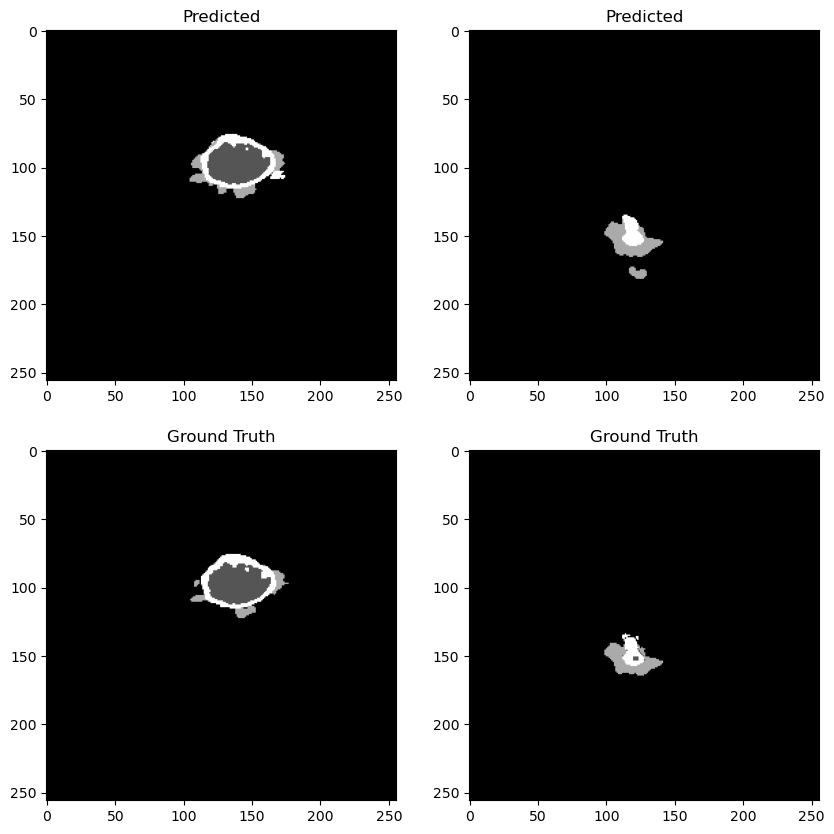

100%|██████████| 15883/15883 [1:30:03<00:00,  2.94it/s]



Average Training Loss: 0.7485835633237063

Average Training DSC: [0.99808821 0.82276394 0.78848597 0.70887511]
Average Training ASSD: [ 0.42712279 30.41478939 32.28371624 29.72514273]


  0%|          | 0/3971 [00:00<?, ?it/s]

Validation Prediction Visualization:


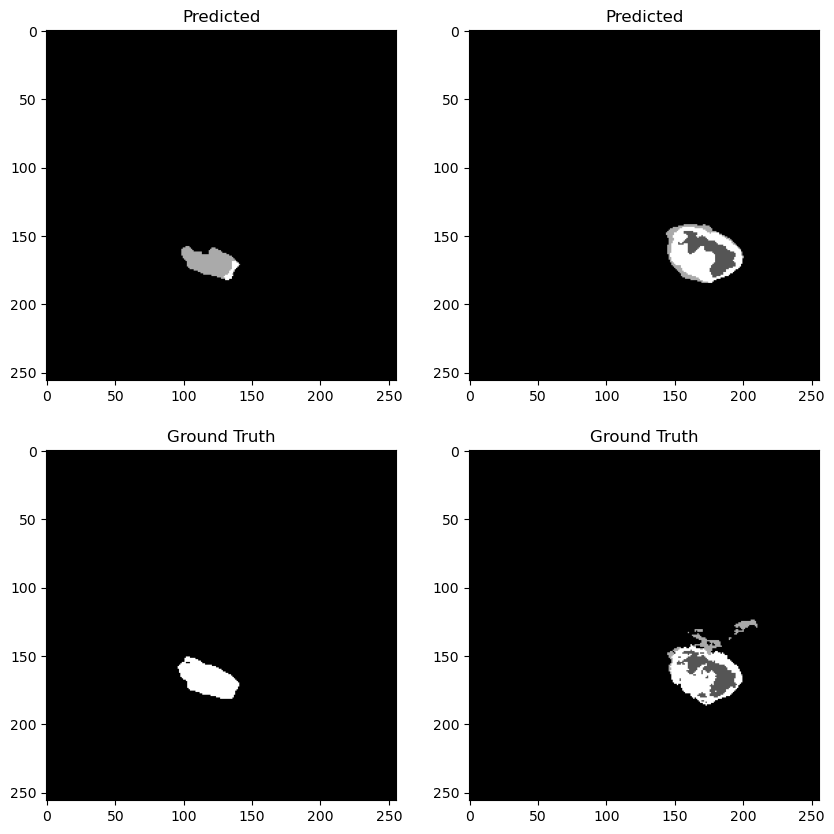

100%|██████████| 3971/3971 [10:44<00:00,  6.16it/s]


Average Validation Loss: 0.7480523692243677

Average Validation DSC: [0.9982082  0.84214867 0.80343716 0.71079326]
Average Validation ASSD: [ 0.44478901 27.52101701 29.39501293 38.50256159]
Epoch 3/50
-------------------------


  0%|          | 0/15883 [00:00<?, ?it/s]

Training Prediction Visualization:


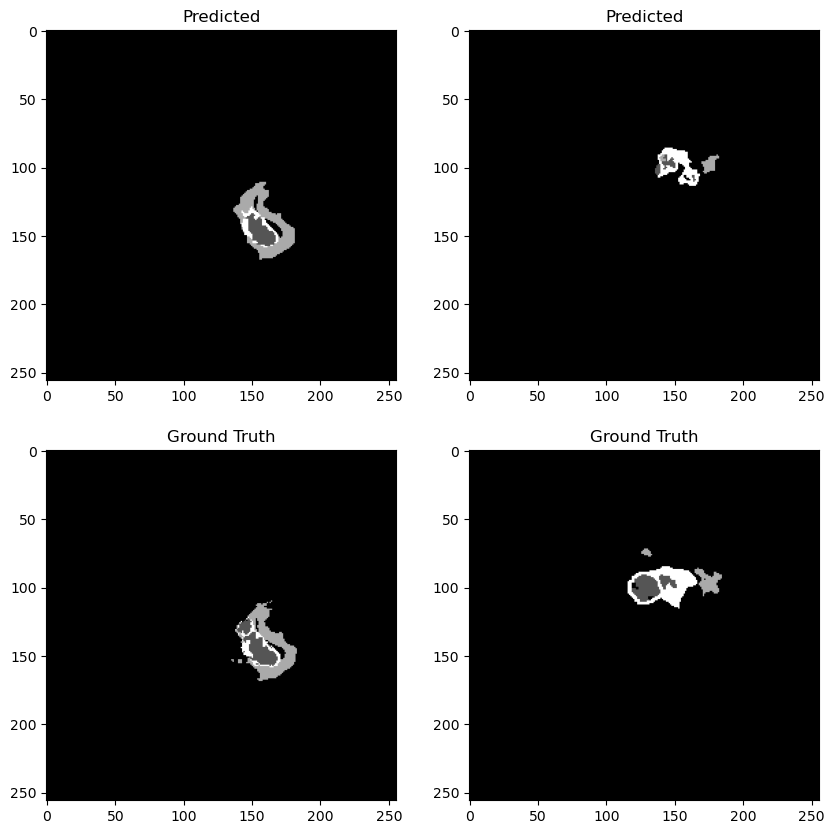

100%|██████████| 15883/15883 [1:30:41<00:00,  2.92it/s]



Average Training Loss: 0.7479903885529082

Average Training DSC: [0.99831601 0.83610031 0.81007045 0.72998518]
Average Training ASSD: [ 0.3661869  28.02253694 28.50235348 27.07901697]


  0%|          | 0/3971 [00:00<?, ?it/s]

Validation Prediction Visualization:


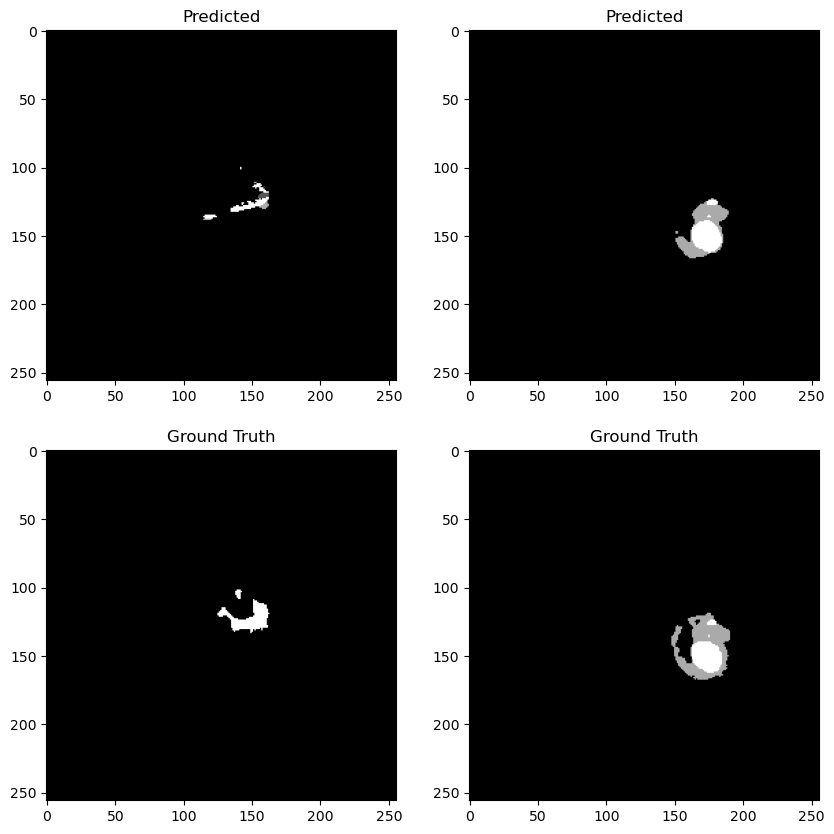

100%|██████████| 3971/3971 [10:46<00:00,  6.14it/s]


Average Validation Loss: 0.7477507400920966

Average Validation DSC: [0.99842382 0.84635616 0.83267897 0.73769227]
Average Validation ASSD: [ 0.36249968 26.09312461 22.28588673 29.0709353 ]
Epoch 4/50
-------------------------


  0%|          | 0/15883 [00:00<?, ?it/s]

Training Prediction Visualization:


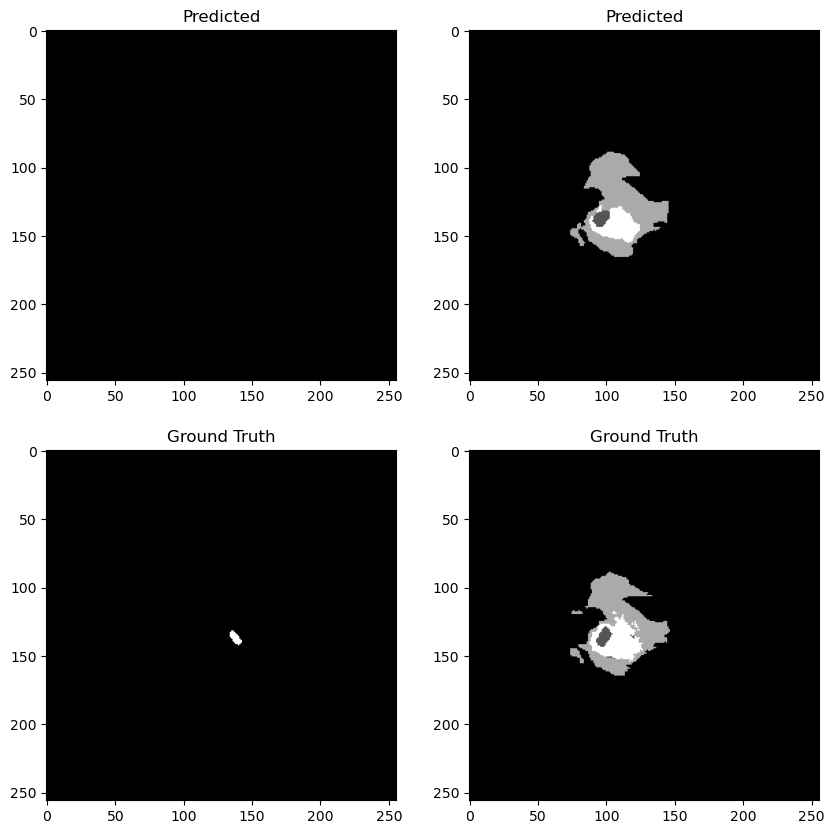

100%|██████████| 15883/15883 [1:30:31<00:00,  2.92it/s]



Average Training Loss: 0.7475798548239871

Average Training DSC: [0.99846168 0.84545073 0.82601759 0.74466888]
Average Training ASSD: [ 0.33350457 25.97469909 25.30181485 25.37472373]


  0%|          | 0/3971 [00:00<?, ?it/s]

Validation Prediction Visualization:


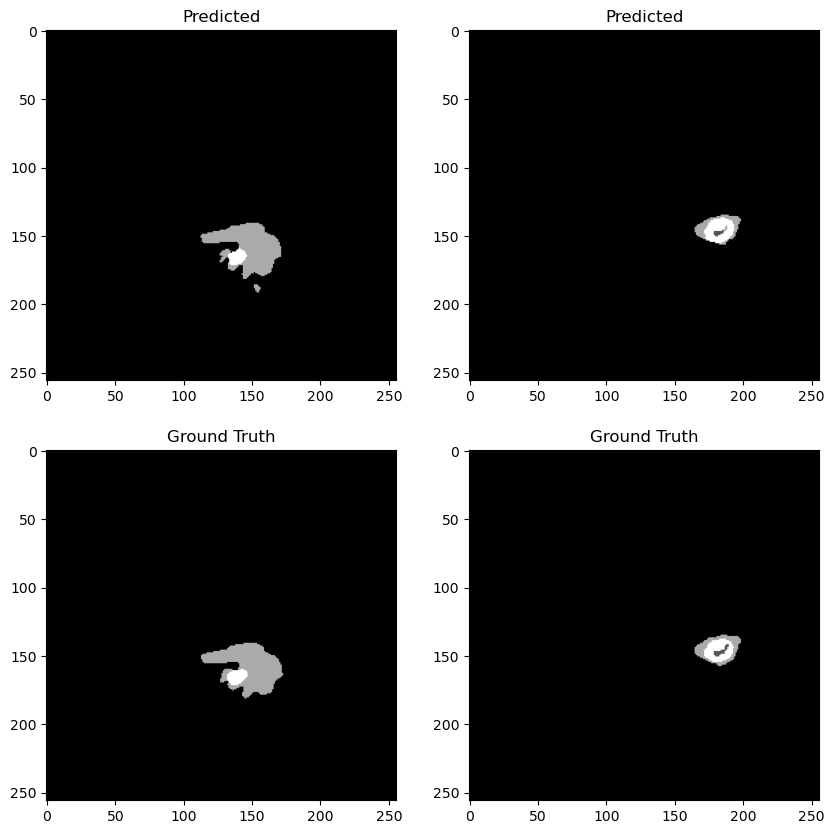

 50%|████▉     | 1975/3971 [05:21<05:46,  5.76it/s]

In [ ]:
model = train_model(num_epochs = 50)